In [1]:
import os
import pandas as pd
import ipdb
from datetime import datetime, time

In [2]:
from index import add_xl_to_csv

In [3]:
%ls data

PeopleFootfall (1).xlsx      weekly-2020-02-10 0925.xlsx


In [14]:
xl_fn = 'data/PeopleFootfall (1).xlsx'
df = (
    add_xl_to_csv(xl_fn, '2020.csv')
    .assign(date = lambda x: x.datetime.dt.normalize())
)
df

,datetime,library,opening_type,people_in,people_out,date
0,2020-01-01 00:00:00,Chipping Barnet,closed,0,0,2020-01-01
1,2020-01-01 00:00:00,Colindale,closed,0,0,2020-01-01
2,2020-01-01 00:00:00,Edgware,closed,0,0,2020-01-01
3,2020-01-01 00:00:00,Finchley Church End,closed,0,0,2020-01-01
4,2020-01-01 00:00:00,Golders Green,closed,0,0,2020-01-01
...,...,...,...,...,...,...
489,2020-03-01 23:00:00,Colindale,closed,0,0,2020-03-01
492,2020-03-01 23:00:00,Edgware,closed,0,0,2020-03-01
495,2020-03-01 23:00:00,Golders Green,closed,0,0,2020-03-01
498,2020-03-01 23:00:00,North Finchley,closed,0,0,2020-03-01


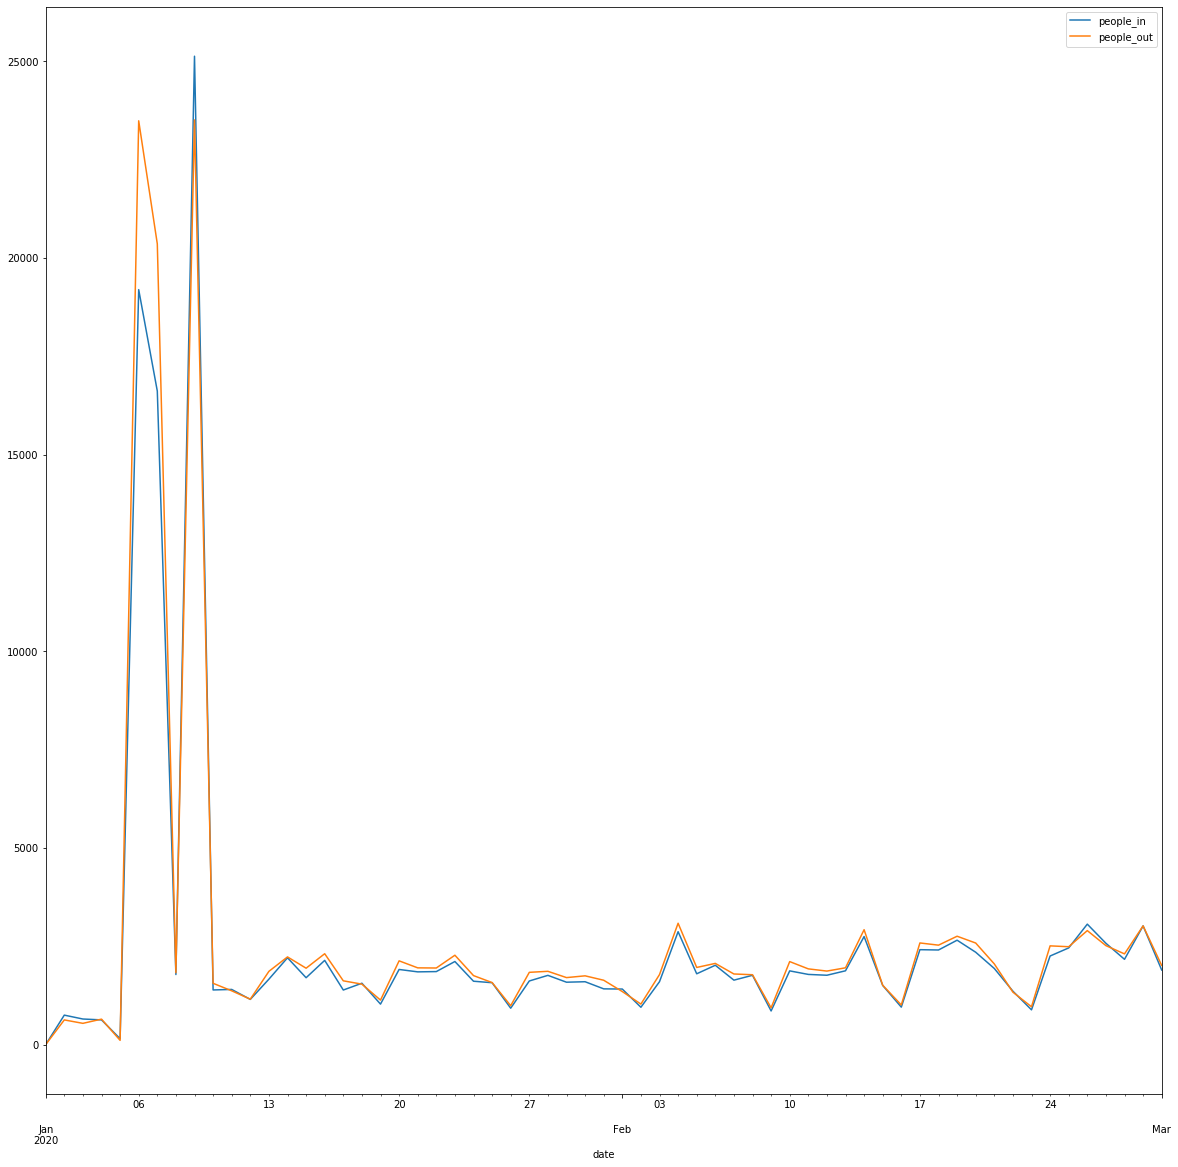

In [15]:
%matplotlib inline
df.groupby('date').sum().plot(figsize=(20,20))

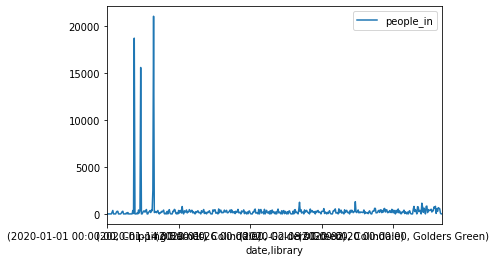

In [27]:
grouped = df.groupby(['date', 'library']).sum().drop('people_out', axis=1)
grouped.plot()